# LGBM Plan

Important to Note
1. Null Values (plan is to for now, just ignore. focus on this once we get the main trends down for non-na products)
2. Long-term predictions (we need to figure out how to feature engineer with cycles)

    7 years train, 3 years test

## Features

1. Cycles
    - yearly
    - weekly (day of week)
    - monthly
    - biyearly
    - automatically calculate cycles?

within a product/store/country combo

how to capture cyclic behavior?
- same doy 3+ / day before, week before, avg. of year
- same month 3+ years ago / other months same year
    - same but averaged over all available years
    - num of years

basic datetime features
- year, month, dow, dom, doy, woy, wom, quarter

## Modelling Plan

1. Concat test to train

2. Create features, train lgbm
    - 2010 to 2015 train
    - 2016 validation

3. Visualize predictions in 2017-2019 (test)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
DIRECTORY = './data/'
train = pd.read_csv(DIRECTORY + 'train.csv', parse_dates=['date']).drop(columns='id')
test = pd.read_csv(DIRECTORY + 'test.csv', parse_dates=['date']).drop(columns='id')

In [10]:
# Clean
train = train.dropna(axis=0)
test['num_sold'] = 0
combined = pd.concat([train, test])

In [12]:
chosenCombo = ['Holographic Goose', 'Discount Stickers', 'Canada']
train[(train['product'] == chosenCombo[0]) & (train['store'] == chosenCombo[1]) & (train['country'] == chosenCombo[2])]

,date,country,store,product,num_sold
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,973.0
90,2010-01-02,Canada,Discount Stickers,Holographic Goose,881.0
180,2010-01-03,Canada,Discount Stickers,Holographic Goose,1003.0
270,2010-01-04,Canada,Discount Stickers,Holographic Goose,744.0
360,2010-01-05,Canada,Discount Stickers,Holographic Goose,707.0
...,...,...,...,...,...
229680,2016-12-27,Canada,Discount Stickers,Holographic Goose,694.0
229770,2016-12-28,Canada,Discount Stickers,Holographic Goose,810.0
229860,2016-12-29,Canada,Discount Stickers,Holographic Goose,856.0
229950,2016-12-30,Canada,Discount Stickers,Holographic Goose,939.0


In [13]:
def date_features(df: pd.DataFrame):
    assert('date' in df.columns)
    df['year'] = df['date'].dt.year - df['date'].dt.year.min()
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.day_of_week
    df['day_of_year'] = df['date'].dt.day_of_year
    df['quarter'] = df['date'].dt.quarter
    df['week_of_year'] = df['date'].dt.day_of_year // 52
    df['month_of_2y'] = (df['year']*12 + df['month']) % 24

    for col, freq in zip(['month', 'day_of_week', 'day_of_year', 'quarter', 'week_of_year', 'month_of_2y'], \
                         [12, 7, 365.25, 4, 52, 24]):
        df[f'sin_{col}'] = np.sin(2 * np.pi * df[col] / freq)
        df[f'cos_{col}'] = np.cos(2 * np.pi * df[col] / freq)
    return df

combined = date_features(combined)

In [14]:
def lag_ratios(df: pd.DataFrame, lag_numerator, rolling_numerator, \
               lag_denominator, rolling_denominator):
    
    # convert to timedelta
    numerator_name = f'lag{lag_numerator}_roll{rolling_numerator}'
    denominator_name = f'lag{lag_numerator}_roll{rolling_denominator}'
    lag_numerator = pd.to_timedelta(lag_numerator)
    rolling_numerator = pd.to_timedelta(rolling_numerator)
    lag_denominator = pd.to_timedelta(lag_denominator)
    rolling_denominator = pd.to_timedelta(rolling_denominator)

    # shift and merge num
    if numerator_name not in df.columns:
        numerator_df = df.set_index('date').groupby(by=['product', 'store', 'country'])['num_sold'] \
            .rolling(rolling_numerator).mean().to_frame(numerator_name).reset_index()
        numerator_df['date'] = numerator_df['date'] + lag_numerator
        df = df.merge(numerator_df, on=['date', 'product', 'store', 'country'], how='left')

    # shift and merge den
    if denominator_name not in df.columns:
        denominator_df = df.set_index('date').groupby(by=['product', 'store', 'country'])['num_sold']\
            .rolling(rolling_denominator).mean().to_frame(denominator_name).reset_index()
        denominator_df['date'] = denominator_df['date'] + lag_denominator
        df = df.merge(denominator_df, on=['date', 'product', 'store', 'country'], how='left')

    df[f'ratio({numerator_name}/{denominator_name})'] = df[numerator_name] / df[denominator_name]
    return df

for yearLag in ['1096D', '1461D', '1826D']:
    for rollingDenominator in ['7D', '30D', '365D', '60D']:
        combined = lag_ratios(combined, yearLag, '1D', yearLag, rollingDenominator)


# Modelling with LGBM

In [15]:
def compress_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Factorize object
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')

    # Downcast numeric
    for col in df.select_dtypes(include=['int', 'float']).columns:
        col_type = df[col].dtype
        if col_type == 'int' or col_type == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif col_type == 'float' or col_type == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
    
    # Optimize object columns
    return df

final_df = compress_dataframe(combined)

In [16]:
train_boundary = pd.to_datetime('2016-01-01')
validation_boundary = pd.to_datetime('2017-01-01')

train_df = final_df[final_df.date < train_boundary]
val_df = final_df[(final_df.date >= train_boundary) & (final_df.date < validation_boundary)]
test_df = final_df[final_df.date >= validation_boundary]

train_X, train_Y = train_df.drop(columns=['num_sold', 'date']), np.log1p(train_df['num_sold'])
train_set = lgb.Dataset(train_X, train_Y)

val_X, val_Y = val_df.drop(columns=['num_sold', 'date']), np.log1p(val_df['num_sold'])
val_set = lgb.Dataset(val_X, val_Y)

test_X, test_Y = test_df.drop(columns=['num_sold', 'date']), np.log1p(test_df['num_sold'])
test_set = lgb.Dataset(test_X, test_Y)

In [17]:
params = {
    'objective': 'regression',
    'metric': 'mape',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1
}

callbacks = [
    lgb.early_stopping(stopping_rounds=50, verbose=True),
    lgb.log_evaluation(period=100)
]

model = lgb.train(
    params,
    train_set,
    valid_sets=[train_set, val_set],
    valid_names=['train', 'validation'],
    num_boost_round=5000,
    callbacks=callbacks
)

Training until validation scores don't improve for 50 rounds
[100]	train's mape: 0.130663	validation's mape: 0.0998115
[200]	train's mape: 0.0588025	validation's mape: 0.0404277
[300]	train's mape: 0.0313518	validation's mape: 0.0233384
[400]	train's mape: 0.020752	validation's mape: 0.0178286
[500]	train's mape: 0.0163982	validation's mape: 0.0157247
[600]	train's mape: 0.0142304	validation's mape: 0.0146381
[700]	train's mape: 0.0128106	validation's mape: 0.0140127
[800]	train's mape: 0.0118829	validation's mape: 0.0135787
[900]	train's mape: 0.0112121	validation's mape: 0.0133011
[1000]	train's mape: 0.0107838	validation's mape: 0.0130935
[1100]	train's mape: 0.010423	validation's mape: 0.0128944
[1200]	train's mape: 0.0101219	validation's mape: 0.0127557
[1300]	train's mape: 0.00990518	validation's mape: 0.0125952
[1400]	train's mape: 0.00972491	validation's mape: 0.0124807
[1500]	train's mape: 0.00958103	validation's mape: 0.0123974
[1600]	train's mape: 0.00948206	validation's map

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

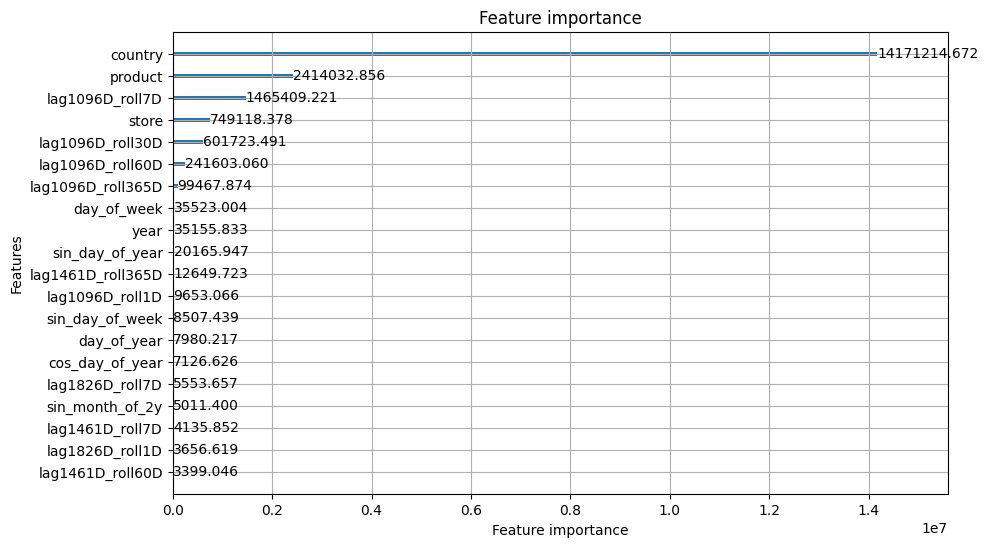

In [18]:
lgb.plot_importance(model, max_num_features=20, importance_type='gain', figsize=(10, 6))

In [19]:
train_prediction = np.expm1(model.predict(train_X))
val_prediction = np.expm1(model.predict(val_X))
test_prediction = np.expm1(model.predict(test_X))

val_df['prediction'] = val_prediction
test_df['prediction'] = test_prediction

/var/folders/_c/j62lsd3n7x9_vq272kdsl3fc0000gn/T/ipykernel_60488/4238897069.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['prediction'] = val_prediction
/var/folders/_c/j62lsd3n7x9_vq272kdsl3fc0000gn/T/ipykernel_60488/4238897069.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['prediction'] = test_prediction


In [20]:
print("Train MSE:", mean_absolute_percentage_error(train_df['num_sold'], train_prediction))
print("Validation MSE:", mean_absolute_percentage_error(val_df['num_sold'], val_prediction))

Train MSE: 0.044977176053782764
Validation MSE: 0.06693121300203737


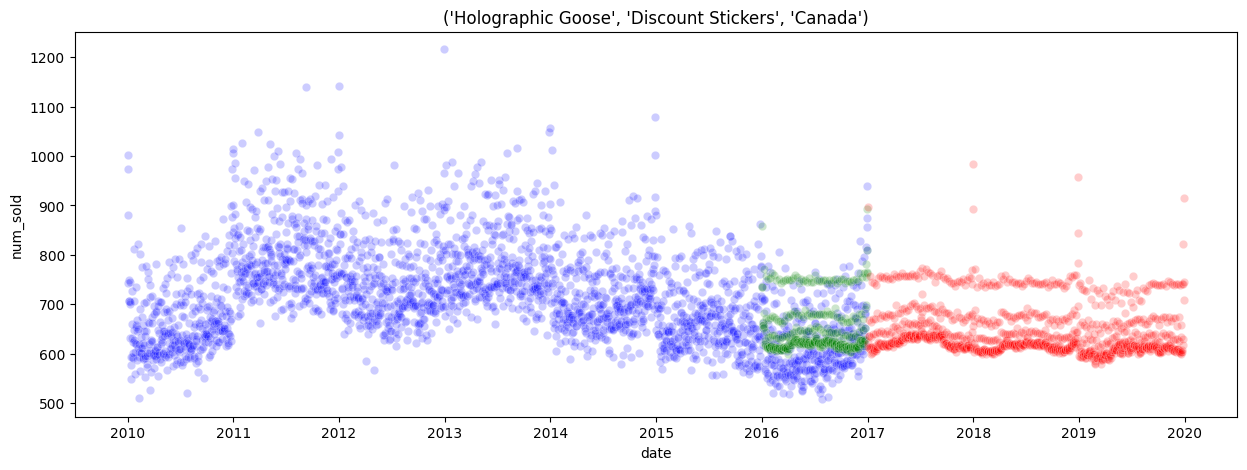

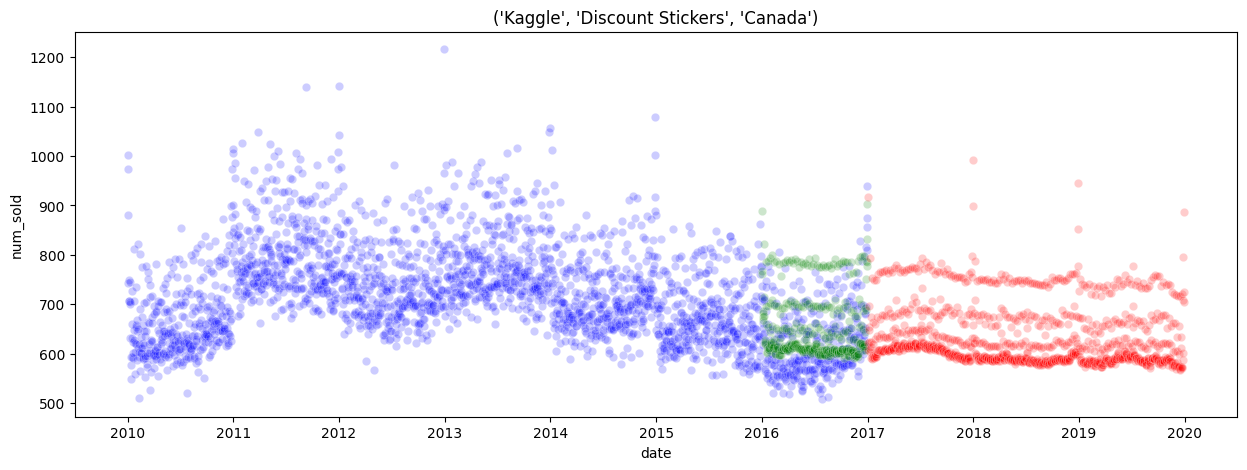

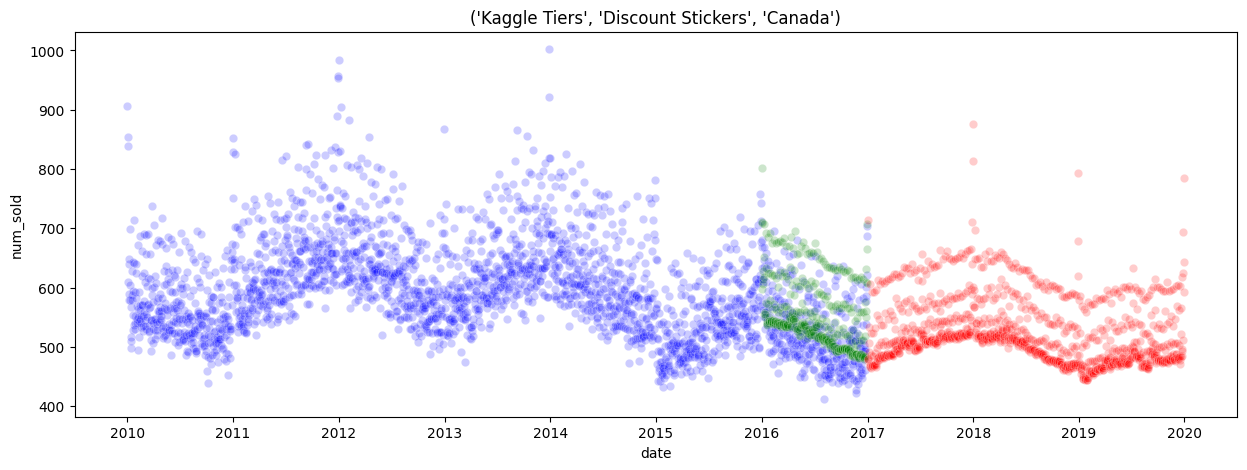

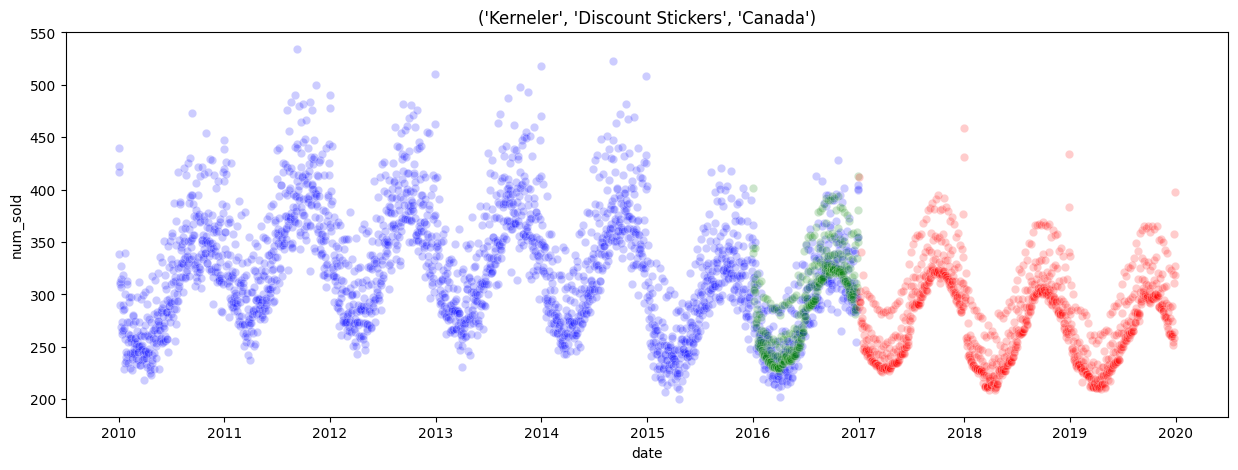

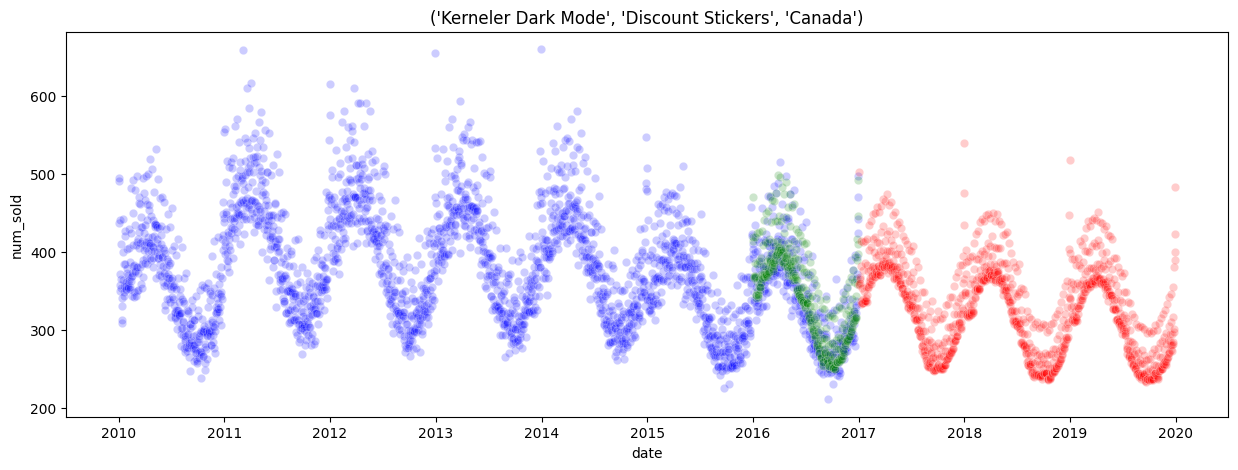

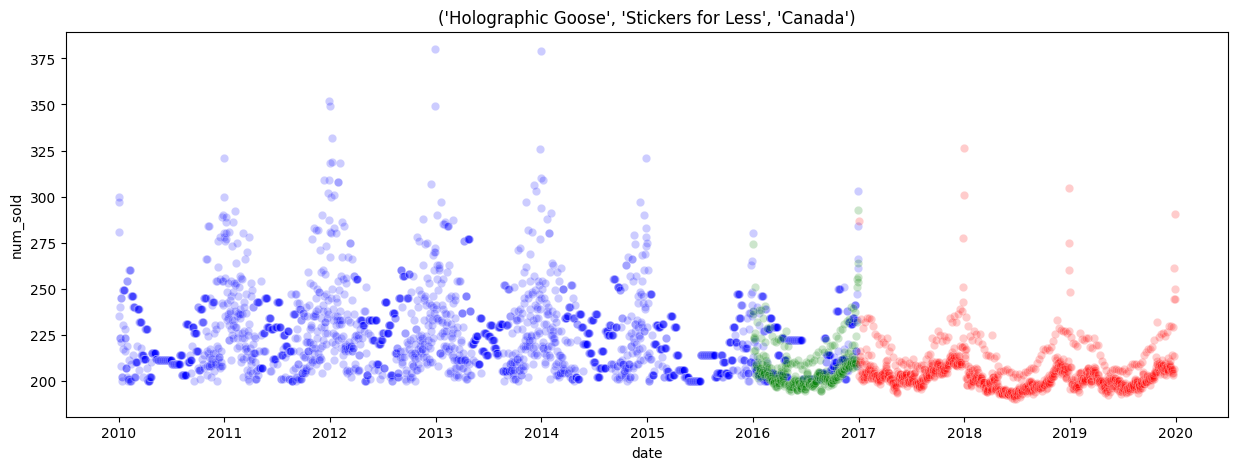

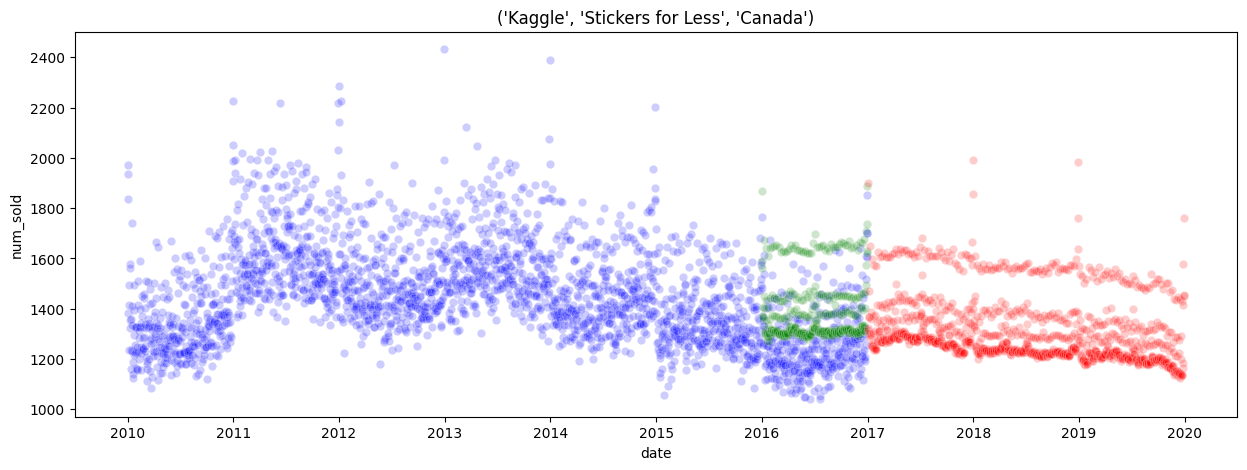

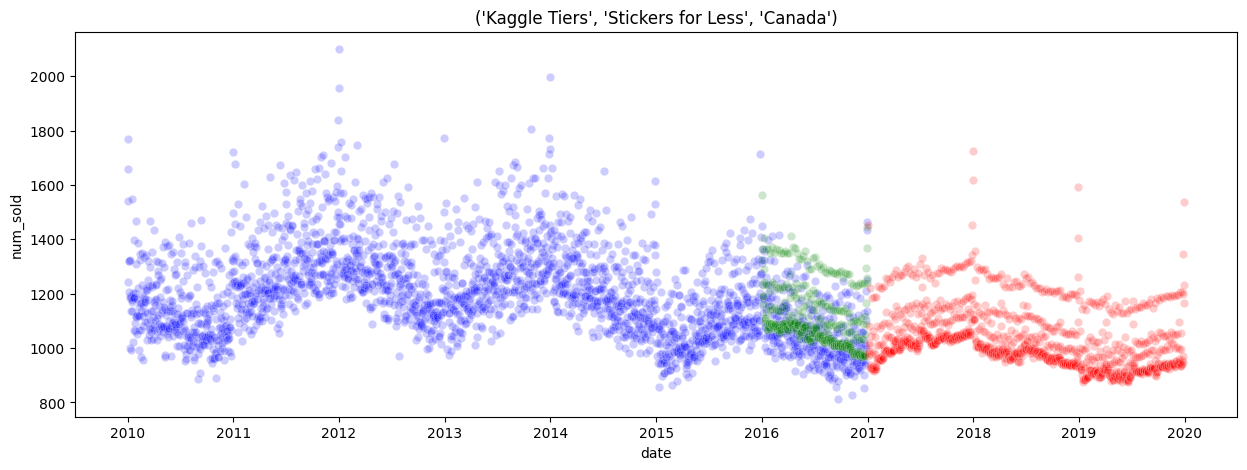

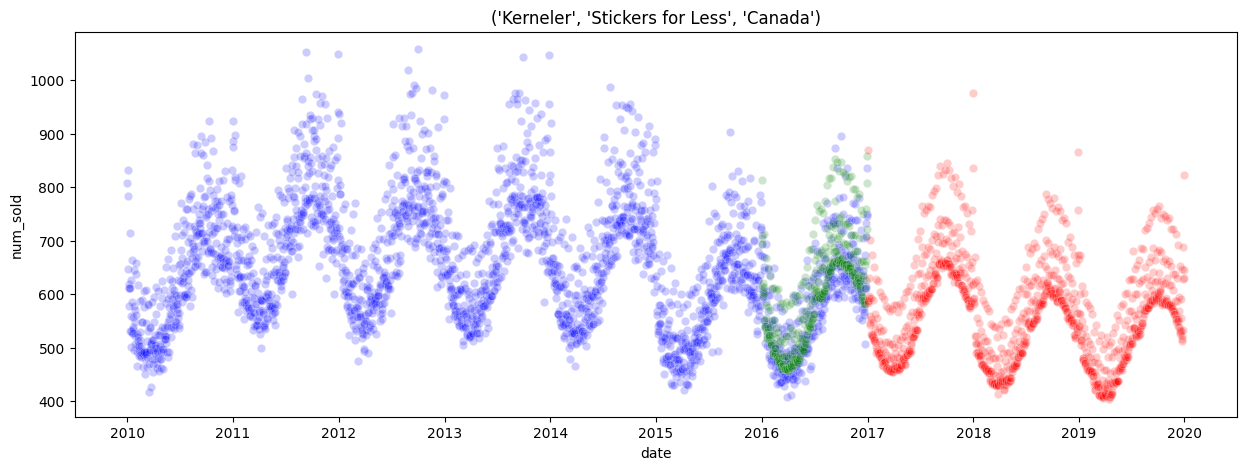

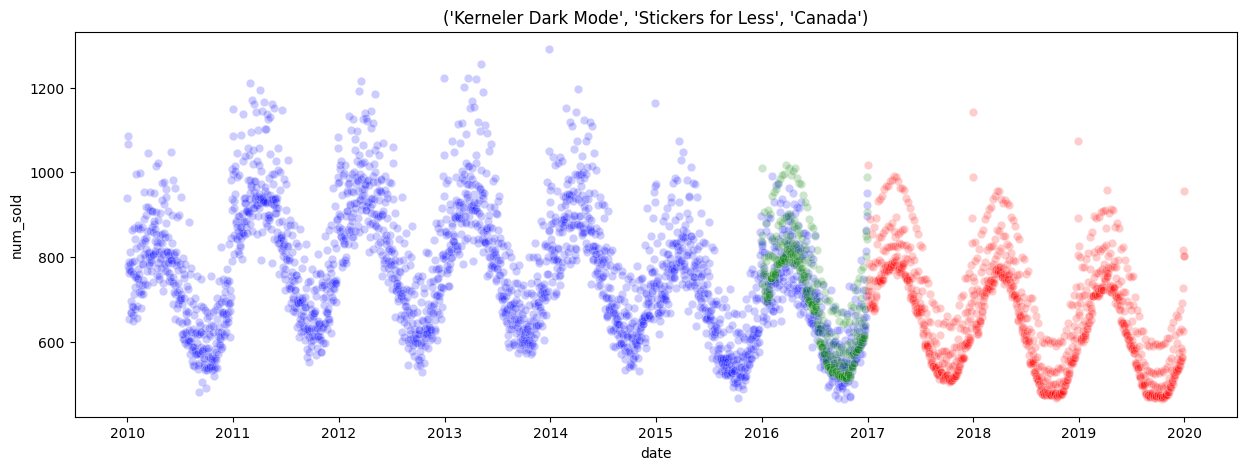

In [21]:
# Graph the results
index_cols = ['product', 'store', 'country']
combos = final_df[index_cols].drop_duplicates().set_index(index_cols).index

plot_train_df = train_df.set_index(index_cols).sort_index()
plot_val_df = val_df.set_index(index_cols).sort_index()
plot_test_df = test_df.set_index(index_cols).sort_index()

for combo in combos[:10]:
    plt.figure(figsize=(15,5))
    sns.scatterplot(data=plot_train_df.loc[combo], x='date', y='num_sold', alpha=0.2, color='blue')
    sns.scatterplot(data=plot_val_df.loc[combo], x='date', y='num_sold', alpha=0.2, color='blue')
    sns.scatterplot(data=plot_val_df.loc[combo], x='date', y='prediction', alpha=0.2, color='green')
    sns.scatterplot(data=plot_test_df.loc[combo], x='date', y='prediction', alpha=0.2, color='red')
    plt.title(combo)
    plt.show()

In [22]:
test = pd.read_csv(DIRECTORY + 'test.csv', parse_dates=['date'])
test = test.merge(right=test_df, on=['date', 'country', 'store', 'product'], how='left')

# combo1 = ['Holographic Goose', 'Discount Stickers', 'Canada']
# test['prediction'] = np.where((test['product'] == combo1[0]) & (test['store'] == combo1[1]) & (test['country'] == combo1[2]), 200, test['prediction'])

# combo2 = ['Holographic Goose', 'Discount Stickers', 'Kenya']
# test['prediction'] = np.where((test['product'] == combo2[0]) & (test['store'] == combo2[1]) & (test['country'] == combo2[2]), 5, test['prediction'])

In [26]:
test['prediction'].describe()

count    98550.000000
mean       666.783018
std        610.194403
min          4.985648
25%        194.299533
50%        522.706511
75%        981.204257
max       4121.262908
Name: prediction, dtype: float64

In [27]:
test[['id', 'prediction']].to_csv('first_submission.csv', index=False)